In [1]:
import torch
import matplotlib.pyplot as plt
from vrnn import utils
from vrnn.data_thermal import Dataset3DThermal
import numpy as np


device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dtype = torch.float32

data_dir = utils.get_data_dir()

import shutil
import matplotlib
plt.rcParams["text.usetex"] = True if shutil.which('latex') else False
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

Using device: cpu


In [2]:

model_file_0 = data_dir / 'Thermal3D_models/vrnn_therm3D_20250320_052451.pt'

model_file_1 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vrnn1per_therm3D_20250326_095659.pt'

# model_file_2 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vrnn6per_therm3D_20250326_150119.pt'
# model_file_2 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vrnn6per_therm3D_20250326_202436.pt'
model_file_2 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vrnn6per_therm3D_20250327_083529.pt'

model_file_3 = data_dir / 'Thermal3D_models/vann_therm3D_20250326_173149.pt'

model_file_4 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vann1per_therm3D_20250326_132331.pt'

# model_file_5 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vann6per_therm3D_20250326_140227.pt'
model_file_5 = data_dir / 'Thermal3D_models/sweep_over_num_samples/vann6per_therm3D_20250327_105128.pt'


In [3]:
# Load hdf5 files
h5_file = data_dir / 'FANS_3D.h5'

dtypes = {'images': torch.bfloat16, 'features': torch.float32, 'targets': torch.float32}

# Load data
feature_idx = None
R_range_train = [1/100., 1/50., 1/20., 1/10., 1/5., 1/2., 2, 5, 10, 20, 50, 100]
train_data = Dataset3DThermal(file_name=h5_file, 
                              R_range=R_range_train, 
                              group='structures_train', 
                              input_mode='descriptors',
                              feature_idx=feature_idx, 
                              device=device,
                              dtypes=dtypes)
R_range_val = np.concatenate([np.arange(2, 101, dtype=int), 1. / np.arange(1, 101, dtype=int)])
# R_range_val = np.concatenate([np.arange(2, 11, dtype=int), 1. / np.arange(1, 11, dtype=int)])
val_data = Dataset3DThermal(file_name=h5_file,
                            R_range=R_range_val,
                            group='structures_val',
                            input_mode='descriptors',
                            feature_idx=feature_idx,
                            device=device,
                            dtypes=dtypes,
                            max_samples=2000)

# Fetch data
train_x, train_y = train_data.features, train_data.targets
val_x, val_y = val_data.features, val_data.targets

In [4]:
from vrnn.tensortools import unpack_sym

def compute_extended_errors(x, y, y_pred, f1_range=None):
    """
    Computes mean, standard deviation, median, min, max of relative and absolute errors
    for each phase contrast value and returns the full set of errors as well.

    Args:
    - x: Input tensor containing data features.
    - y: Ground truth tensor.
    - y_pred: Predicted output tensor.
    - f1_range: Optional tuple (f1_min, f1_max) to filter data by first feature range (f1).

    Returns:
    - stats: Dictionary with extended statistics (mean, std, median, min, max) 
             for relative and absolute errors for each phase contrast.
    - all_rel_errs: Dictionary with full relative errors for each phase contrast.
    - all_abs_errs: Dictionary with full absolute errors for each phase contrast.
    """
    # Extract unique phase contrasts
    phase_contrasts = torch.unique(x[..., -1]).cpu().numpy()

    # Dictionary to hold statistics
    stats = {}
    all_rel_errs = {}
    all_abs_errs = {}

    for phase_contrast in phase_contrasts:
        # Filter by phase contrast and optional f1 range
        mask = x[:, -1] == phase_contrast
        if f1_range is not None:
            f1_min, f1_max = f1_range
            mask = mask * (x[:, 0] > f1_min) * (x[:, 0] < f1_max)

        # Filtered data
        y_filter = y[mask]
        y_pred_filter = y_pred[mask]

        abs_err = torch.norm(unpack_sym(y_filter, dim=3) - unpack_sym(y_pred_filter, dim=3), 'fro', dim=(1,2))
        rel_err = abs_err / torch.norm(unpack_sym(y_filter, dim=3), 'fro', dim=(1,2))

        # Store the full set of errors
        all_rel_errs[phase_contrast.item()] = rel_err.cpu()
        all_abs_errs[phase_contrast.item()] = abs_err.cpu()

        # Store statistics
        stats[phase_contrast.item()] = {
            'mean_rel_err': rel_err.mean().cpu(),
            'std_rel_err': rel_err.std().cpu(),
            'median_rel_err': rel_err.median().cpu(),
            'min_rel_err': rel_err.min().cpu(),
            'max_rel_err': rel_err.max().cpu(),
            'mean_abs_err': abs_err.mean().cpu(),
            'std_abs_err': abs_err.std().cpu(),
            'median_abs_err': abs_err.median().cpu(),
            'min_abs_err': abs_err.min().cpu(),
            'max_abs_err': abs_err.max().cpu(),
        }

    return stats, all_rel_errs, all_abs_errs


def querymodelgetrelerror(model_file_name):
    
    model = torch.load(model_file_name, map_location=device, weights_only=False).to(device=device, dtype=dtype)
    model.eval()

    with torch.inference_mode():
        train_pred = model(train_x)
        val_pred = model(val_x)

    rel_err_train = torch.norm(unpack_sym(train_y, dim=3) - unpack_sym(train_pred, dim=3), 'fro', dim=(1,2)) / torch.norm(unpack_sym(train_y, dim=3), 'fro', dim=(1,2))
    rel_err_val = torch.norm(unpack_sym(val_y, dim=3) - unpack_sym(val_pred, dim=3), 'fro', dim=(1,2)) / torch.norm(unpack_sym(val_y, dim=3), 'fro', dim=(1,2))
    
    val_stats, val_all_rel_errs, val_all_abs_errs = compute_extended_errors(val_x, val_y, val_pred)
    
    return rel_err_train, rel_err_val, val_stats, val_all_rel_errs, val_all_abs_errs


err_train_model_0, err_val_model_0, val_stats_0, val_all_rel_errs_0, val_all_abs_errs_0 = querymodelgetrelerror(model_file_0)
err_train_model_1, err_val_model_1, val_stats_1, val_all_rel_errs_1, val_all_abs_errs_1 = querymodelgetrelerror(model_file_1)
err_train_model_2, err_val_model_2, val_stats_2, val_all_rel_errs_2, val_all_abs_errs_2 = querymodelgetrelerror(model_file_2)
err_train_model_3, err_val_model_3, val_stats_3, val_all_rel_errs_3, val_all_abs_errs_3 = querymodelgetrelerror(model_file_3)
err_train_model_4, err_val_model_4, val_stats_4, val_all_rel_errs_4, val_all_abs_errs_4 = querymodelgetrelerror(model_file_4)
err_train_model_5, err_val_model_5, val_stats_5, val_all_rel_errs_5, val_all_abs_errs_5 = querymodelgetrelerror(model_file_5)

# err_train_model_0, err_val_model_0 = querymodelgetrelerror(model_file_0)
# err_train_model_1, err_val_model_1 = querymodelgetrelerror(model_file_1)
# err_train_model_2, err_val_model_2 = querymodelgetrelerror(model_file_2)
# err_train_model_3, err_val_model_3 = querymodelgetrelerror(model_file_3)
# err_train_model_4, err_val_model_4 = querymodelgetrelerror(model_file_4)
# err_train_model_5, err_val_model_5 = querymodelgetrelerror(model_file_5)

In [5]:
# Isotropic projection of the data

mean_diag = torch.mean(val_y[:, :3], dim=1, keepdim=True)
val_y_iso = torch.zeros_like(val_y)
val_y_iso[:, 0:3] = mean_diag.expand(-1, 3) 

err_val_model_iso = torch.norm(unpack_sym(val_y, dim=3) - unpack_sym(val_y_iso, dim=3), 'fro', dim=(1,2)) / torch.norm(unpack_sym(val_y, dim=3), 'fro', dim=(1,2))

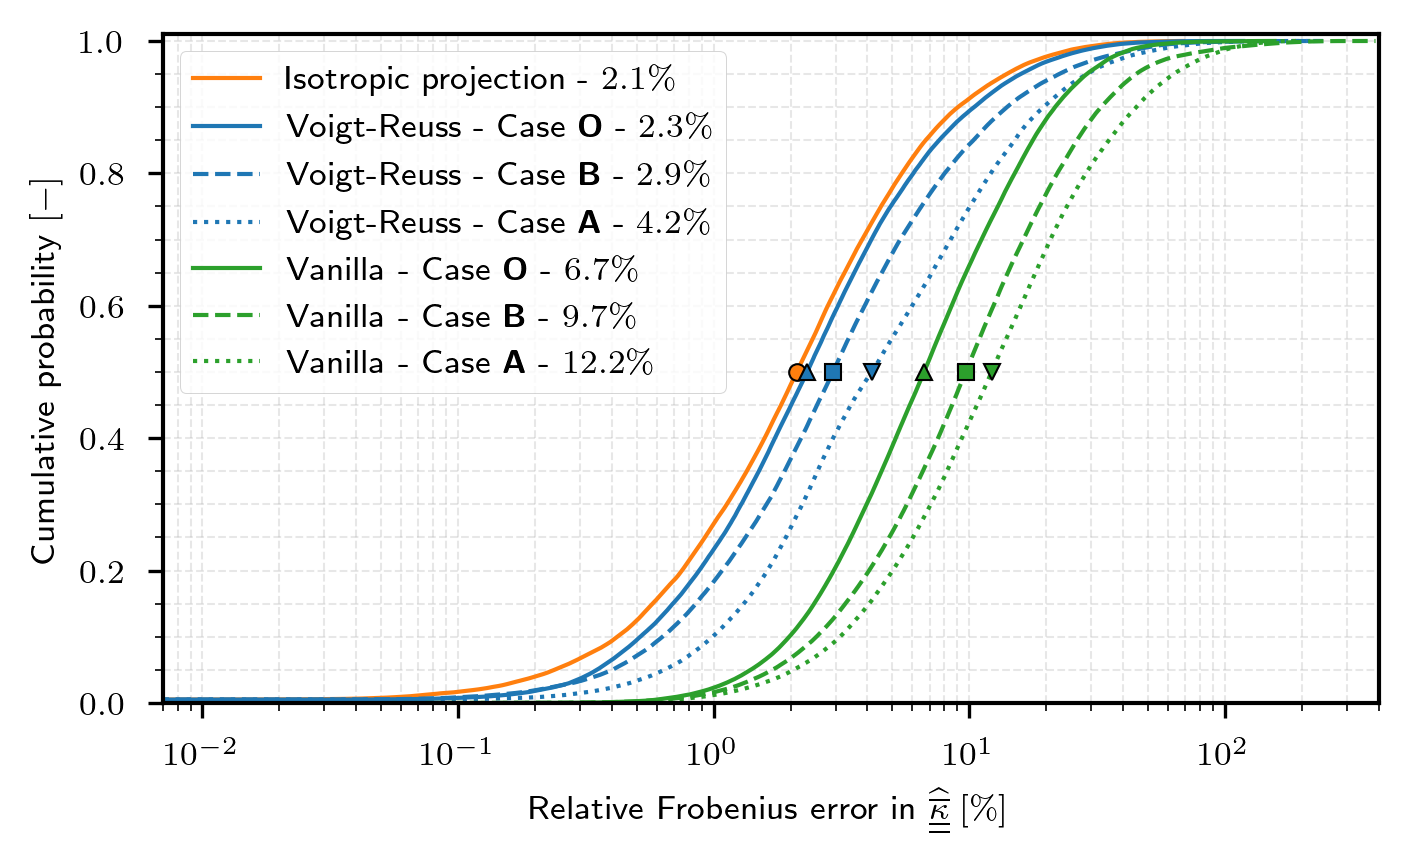

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_error_cdf(error_list, labels, colors=None, line_styles=None, marker_styles=None, figsize=(5.3, 5.3*0.55)):
        """
        Plot CDFs of relative errors for multiple models.
        
        Parameters:
        ----------
        error_list : list of torch.Tensor or numpy.ndarray
                List of error tensors for different models
        labels : list of str
                List of labels for each model
        colors : list of str, optional
                List of colors for each model (default: automatic)
        line_styles : list of str, optional
                List of line styles for each model (default: solid lines)
        figsize : tuple, optional
                Figure size (width, height)
        """
        # Set style parameters
        fontsize = 8
        plt.rcParams.update({'font.size': fontsize})
        plt.style.use('seaborn-v0_8-paper')
        plt.rcParams.update({
                'font.size': fontsize,
                'axes.linewidth': 1
        })
        
        # Create default colors and line styles if not provided
        if colors is None:
                colors = plt.cm.tab10(np.linspace(0, 1, len(error_list)))
        if line_styles is None:
                line_styles = ['-'] * len(error_list)
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize, dpi=300)
        
        # Store median values for annotation
        median_vals = []
        
        # Plot each model's error
        for i, (errors, label, color, ls, ms) in enumerate(zip(error_list, labels, colors, line_styles, marker_styles)):
                # Convert to numpy and percentage if needed
                if isinstance(errors, torch.Tensor):
                        rel_errors = errors.cpu().numpy() * 100  # Convert to percentage
                else:
                        rel_errors = np.array(errors) * 100
                
                median_val = np.median(rel_errors)
                median_vals.append(median_val)
                
                quantile_points = np.linspace(0, 1, 10000)
                quantiles = np.quantile(rel_errors, quantile_points)
                label = label + fr' - ${median_val:.1f}\%$'
                ax.plot(quantiles, quantile_points, ls, color=color, linewidth=1, label=label)
                ax.plot(median_val, 0.5, ms, color=color, markersize=4, 
                                markeredgecolor='black', markeredgewidth=0.5)
                
        
        # Set axis limits and labels
        ax.set_xscale('log')
        ax.set_ylim(0, 1.01)
        ax.set_xlabel(r'Relative Frobenius error in $\underline{\underline{\widehat{\overline{\kappa}}}} \; [\%] $', fontsize=fontsize)
        ax.set_ylabel(r'Cumulative probability $[-]$', fontsize=fontsize)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.legend(fontsize=fontsize, loc='upper left')
        ax.set_xlim(7e-3, 4e2)
        
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=fontsize)
        ax.set_box_aspect(0.55)
        
        plt.tight_layout()
        return fig, ax

# Example usage with the existing error data
errors = [err_val_model_iso, err_val_model_0, err_val_model_1, err_val_model_2, err_val_model_3, err_val_model_4, err_val_model_5]
labels = [r'Isotropic projection',
          r'Voigt-Reuss - Case \textbf{O}',
          r'Voigt-Reuss - Case \textbf{B}',
          r'Voigt-Reuss - Case \textbf{A}',
          r'Vanilla - Case \textbf{O}',
          r'Vanilla - Case \textbf{B}',
          r'Vanilla - Case \textbf{A}',]
colors = ['tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:green', 'tab:green', 'tab:green']
line_styles = ['-', '-', '--', ':', '-', '--', ':']
marker_styles = ['o', '^', 's', 'v', '^', 's', 'v']

fig, ax = plot_error_cdf(errors, labels, colors, line_styles, marker_styles)
plt.show()

# Save the figure with high quality
fig.savefig("../../overleaf/gfx/therm3d_ecdf.pdf", 
            bbox_inches='tight', 
            dpi=300,
            metadata={'Creator': '', 'Producer': ''})


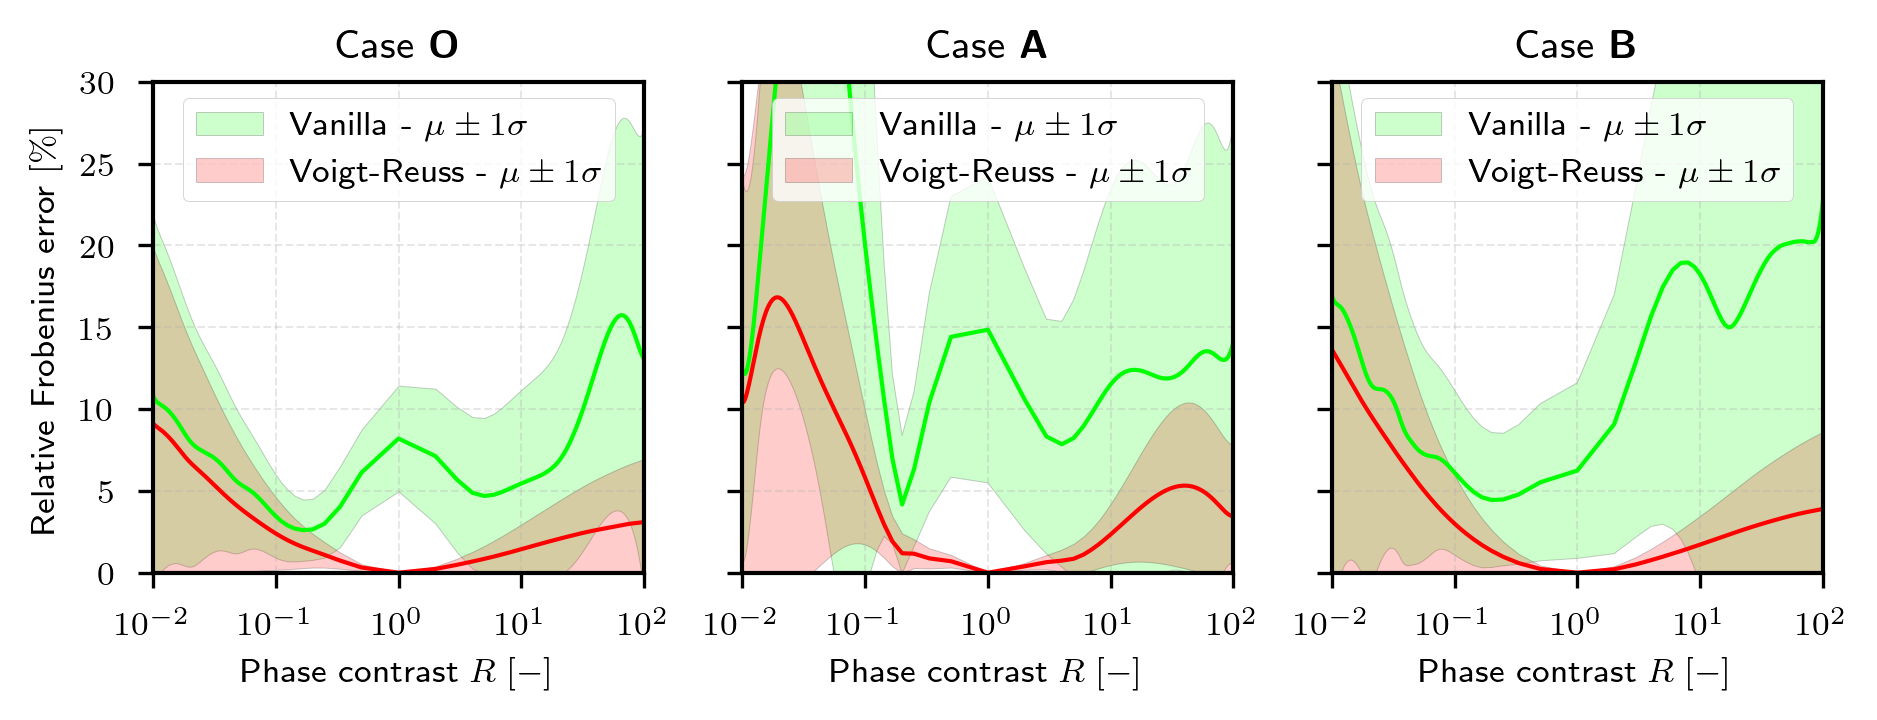

In [7]:
def plot_error_comparison(ax, vanilla_val_stats, vrnn_val_stats, 
                         vanilla_train_stats=None, vrnn_train_stats=None, 
                         vanilla_color='lime', vrnn_color='red',
                         fontsize=8, ylim=(0, 30), xlim=(1e-2, 1e2),
                         show_legend=True, title='Comparison on validation set'):
    """
    Plot error comparison between vanilla and VRNN models.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    vanilla_val_stats : dict
        Stats dictionary for vanilla validation set
    vrnn_val_stats : dict
        Stats dictionary for VRNN validation set
    vanilla_train_stats : dict, optional
        Stats dictionary for vanilla training set
    vrnn_train_stats : dict, optional
        Stats dictionary for VRNN training set
    vanilla_color : str, optional
        Color for vanilla model
    vrnn_color : str, optional
        Color for VRNN model
    fontsize : int, optional
        Font size for labels
    ylim : tuple, optional
        y-axis limits
    xlim : tuple, optional
        x-axis limits
    show_legend : bool, optional
        Whether to show the legend
    title : str, optional
        Plot title
    """
    # Define the keys to use from the stats dictionaries
    stat_quantity = 'mean_rel_err'
    std_quantity = 'std_rel_err'

    # --- Vanilla ANN ---
    x_vanilla = np.array(sorted(vanilla_val_stats.keys()))
    mean_vals_vanilla = np.array([100 * vanilla_val_stats[k][stat_quantity].item() for k in sorted(vanilla_val_stats.keys())])
    std_vals_vanilla = np.array([100 * vanilla_val_stats[k][std_quantity].item() for k in sorted(vanilla_val_stats.keys())])

    upper_bound_vanilla = mean_vals_vanilla + std_vals_vanilla
    lower_bound_vanilla = mean_vals_vanilla - std_vals_vanilla

    ax.fill_between(x_vanilla, lower_bound_vanilla, upper_bound_vanilla, color=vanilla_color, alpha=0.2,
                     label=fr"Vanilla - $\mu \pm 1\sigma$", edgecolor='black')
    ax.plot(x_vanilla, mean_vals_vanilla, color=vanilla_color, linewidth=1)

    if vanilla_train_stats:
        x_train_vanilla = np.array(sorted(vanilla_train_stats.keys()))
        train_mean_vanilla = np.array([100 * vanilla_train_stats[k][stat_quantity].item() for k in sorted(vanilla_train_stats.keys())])
        # ax.scatter(x_train_vanilla, train_mean_vanilla, facecolors=vanilla_color, edgecolors='black', s=10,
        #           label="ANN train - mean")

    # --- VRNN ---
    x_vrnn = np.array(sorted(vrnn_val_stats.keys()))
    mean_vals_vrnn = np.array([100 * vrnn_val_stats[k][stat_quantity].item() for k in sorted(vrnn_val_stats.keys())])
    std_vals_vrnn = np.array([100 * vrnn_val_stats[k][std_quantity].item() for k in sorted(vrnn_val_stats.keys())])

    upper_bound_vrnn = mean_vals_vrnn + std_vals_vrnn
    lower_bound_vrnn = mean_vals_vrnn - std_vals_vrnn

    ax.fill_between(x_vrnn, lower_bound_vrnn, upper_bound_vrnn, color=vrnn_color, alpha=0.2,
                     label=fr"Voigt-Reuss - $\mu \pm 1\sigma$", edgecolor='black')
    ax.plot(x_vrnn, mean_vals_vrnn, color=vrnn_color, linewidth=1)

    if vrnn_train_stats:
        x_train_vrnn = np.array(sorted(vrnn_train_stats.keys()))
        train_mean_vrnn = np.array([100 * vrnn_train_stats[k][stat_quantity].item() for k in sorted(vrnn_train_stats.keys())])
        # ax.scatter(x_train_vrnn, train_mean_vrnn, facecolors=vrnn_color, edgecolors='black', s=10,
        #           label="VRNN training - mean")

    ax.set_xscale('log')
    if show_legend:
        ax.legend(loc='upper center')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_box_aspect(1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.minorticks_off()
    ax.set_title(title)
    ax.set_xlabel(fr'Phase contrast $R \;[-]$', fontsize=fontsize)
    
    return ax

# Set style parameters
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
        'font.size': fontsize,
        'axes.linewidth': 1
})
        
fig, axs = plt.subplots(1, 3, figsize=(6.3, 3), dpi=300)
plot_error_comparison(axs[0], val_stats_3, val_stats_0, None, None, 'lime', 'red', title=r'Case $\textbf{O}$')
plot_error_comparison(axs[1], val_stats_5, val_stats_2, None, None, 'lime', 'red', title=r'Case $\textbf{A}$')
plot_error_comparison(axs[2], val_stats_4, val_stats_1, None, None, 'lime', 'red', title=r'Case $\textbf{B}$')


# Remove y-axis ticks for ax[1] , ax[2]
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

# Set yable on ax[0]
axs[0].set_ylabel(r'Relative Frobenius error $[\%]$', fontsize=fontsize)

plt.tight_layout()
plt.show()

# Save the figure with high quality
fig.savefig("../../overleaf/gfx/therm3d_model_std_comparision.pdf", 
            bbox_inches='tight', 
            dpi=300,
            metadata={'Creator': '', 'Producer': ''})

